In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from saxskit import saxs_math, saxs_fit
from saxskit.saxs_classify import SaxsClassifier
from saxskit.saxs_regression import SaxsRegressor

## Predict populations and scattering parameters from measured data

#### Step 1. Read q (1/A) and Intensity from csv file

In [3]:
q_I = np.genfromtxt ('sample_0.csv', delimiter=",")

#### Step 2. Examine the spectrum

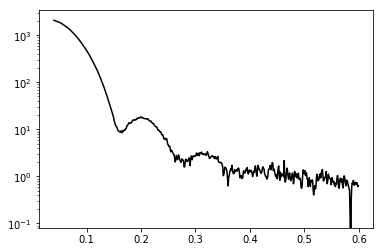

In [4]:
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.show()

#### Step 3. Calculate numerical features (profile) of the spectrum

In [5]:
features = saxs_math.profile_spectrum(q_I)
features

OrderedDict([('Imax_over_Imean', 13.181053776872366),
             ('Imax_sharpness', 1.0200591262893703),
             ('I_fluctuation', 0.001038996426310348),
             ('logI_fluctuation', 5.943073057197209),
             ('logI_max_over_std', 3.2213864774189336),
             ('r_fftIcentroid', 0.10056978331899331),
             ('r_fftImax', 0.0017857142857142857),
             ('q_Icentroid', 0.07198204747458697),
             ('q_logIcentroid', 0.13005159629922175),
             ('pearson_q', -0.5599102444780059),
             ('pearson_q2', -0.4197884860266609),
             ('pearson_expq', -0.5188467663495657),
             ('pearson_invexpq', 0.6012800462298686)])

#### Step 4. Predict scatterer populations

In [6]:
saxs_cls = SaxsClassifier()

populations, certainties = saxs_cls.classify(features)
populations

OrderedDict([('unidentified', 0),
             ('guinier_porod', 0),
             ('spherical_normal', 1),
             ('diffraction_peaks', 0)])

In [7]:
certainties

OrderedDict([('unidentified', 0.9843478393309336),
             ('guinier_porod', 0.7715530051738791),
             ('spherical_normal', 0.9950754648390004),
             ('diffraction_peaks', 0.9963691434061338)])

The saxskit models predict that the data are identifiable and that the scatterers include one population of a normal size distribution of spherical scatterers. The models predict no diffraction peaks with a high certainty, and no Guinier-Porod like terms with a less-high certainty.

#### Step 5. Predict scattering parameters

In [8]:
saxs_reg = SaxsRegressor()

params = saxs_reg.predict_params(populations,features,q_I)
params

OrderedDict([('r0_sphere', [26.770631802929802]),
             ('sigma_sphere', [0.04835286692702404])])

The saxskit models predict the mean sphere size (in Angstroms) and the standard deviation (fractional), assuming a normal size distribution. 

Parameters related to intensity (the intensities of the noise floor and spherical scattering) are now computed by constrained least-squares fitting:

In [9]:
sxf = saxs_fit.SaxsFitter(q_I,populations)
params, report = sxf.fit_intensity_params(params)
params

OrderedDict([('I0_floor', [0.6178472431858584]),
             ('I0_sphere', [2427.586618732092]),
             ('r0_sphere', [26.770631802929802]),
             ('sigma_sphere', [0.04835286692702404])])

#### Step 6. See how predicted parameters reproduce measured spectrum

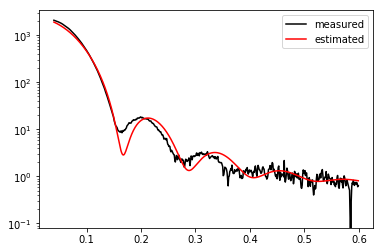

In [10]:
I_estimate = saxs_math.compute_saxs(q_I[:,0],populations,params)
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.semilogy(q_I[:,0],I_estimate,'-r')
plt.legend(['measured','estimated'])
plt.show()

#### Step 7. Refine the parameters by least-squares fitting the spectrum

In [11]:
params_opt, rpt = sxf.fit(params)
params_opt

OrderedDict([('I0_floor', [0.5387307876412822]),
             ('I0_sphere', [2898.2015834464646]),
             ('r0_sphere', [27.69223625995154]),
             ('sigma_sphere', [0.0848985716985228])])

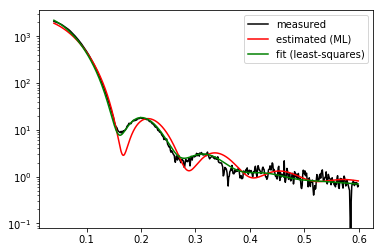

In [12]:
I_opt = saxs_math.compute_saxs(q_I[:,0],populations,params_opt)
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.semilogy(q_I[:,0],I_estimate,'-r')
plt.semilogy(q_I[:,0],I_opt,'-g')
plt.legend(['measured','estimated (ML)','fit (least-squares)'])
plt.show()